## VPRTempo & VPRTempoQuant - Basic Demo

### By Adam D Hines (https://research.qut.edu.au/qcr/people/adam-hines/)

VPRTempo is based on the following paper, if you use or find this code helpful for your research please consider citing the source:
    
[Adam D Hines, Peter G Stratton, Michael Milford, & Tobias Fischer. "VPRTempo: A Fast Temporally Encoded Spiking Neural Network for Visual Place Recognition. arXiv September 2023](https://arxiv.org/abs/2309.10225)

### Introduction

This is a basic, extremely simplified version of VPRTempo that highlights how images are transformed, spikes and weights are used, and the readout for performance using a model trained using our base system and the Quantized Aware Training (QAT) version. This is a basic, extremely simplified version of VPRTempo that highlights how images are transformed, spikes and weights are used, and the readout for performance. Although the proper implementation is in [PyTorch](https://pytorch.org/), we present a simple NumPy example to get started. As in the paper, we will present a simple example using the [Nordland](https://webdiis.unizar.es/~jmfacil/pr-nordland/#download-dataset) dataset with pre-trained set of weights.

Before starting, make sure the following packages are installed and imported:

In [1]:
# Imprt opencv-python, NumPy, and matplotlib.pyplot
try:
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
except:
    ! pip install numpy, opencv-python, matplotlib # pip install if modules not present
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

Next, we will need to get the pretrained weights for the model. To get them and the other materials for the , we will use [Git Large File Storage](https://git-lfs.com/) to download 

### Image processing

Let's have a look at how we process our images to run through VPRTempo. We utilize a technique called *patch normalization* to resize input images and normalize the pixel intensities. To start, let's see what the original image looks like before patch normalization.

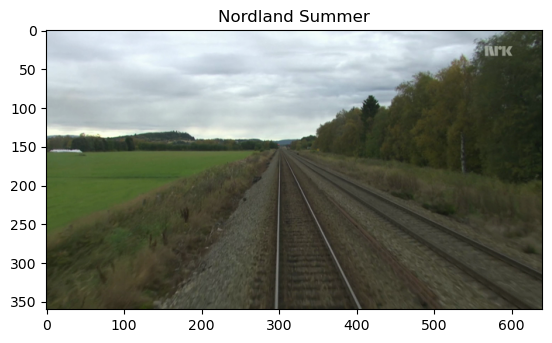

In [4]:
# Load the input image
raw_img = cv2.imread('./mats/1_BasicDemo/summer.png')
rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB) # Convert to RGB

# Plot the image
plt.imshow(rgb_img)
plt.title('Nordland Summer')
plt.show()

What we have here is a 360x640 RGB image, which for processing through neural networks is too big (230,400 total pixels). So instead, we'll use patch normalization to reduce the image size down to a grayscale 56x56 image to just 3136 pixels in total.

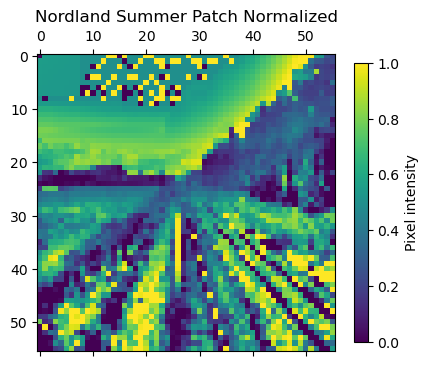

In [7]:
# Load the patch normalized image
patch_img = np.load('./mats/1_BasicDemo/summer_patchnorm.npy', allow_pickle=True)

# Plot the image
plt.matshow(patch_img)
plt.title('Nordland Summer Patch Normalized')
plt.colorbar(shrink=0.75, label="Pixel intensity")
plt.show()

The reduced image dimensions with patch normalization allows for a decent representation of the full scene, despite the smaller size.

### Convert images to spikes

'Spikes' in the context of VPRTempo are a little different than conventional spiking neural networks. Typically, spikes from image datasets are converted into Poisson spike trains where the pixel intensity determines the number of spikes to propagate throughout a network. VPRTempo only considers each pixel as a single spike, but considers the *amplitude* of the spike to determine the timing within a single timestep - where large amplitudes (high pixel intensity) spike early in a timestep, and vice versa for small amplitudes. 

Let's flatten the patch normalized image into a 1D-array so we can apply our network weights.

In [9]:
# Convert 2D image to a 1D-array
patch_1d = np.reshape(patch_img, (3136,))

### Load the pre-trained network weights

Our network consists of the following architecture:

    - An input layer sparsely connected to a feature layer, 784 input neurons to 1568 feature neurons
    - The feature layer fully connected to a one-hot-encoded output layer, 1568 feature neurons to 500 output neurons

Each layer connection is trained separately and stored in different weight matrices for excitatory (positive) and inhibitory (negative) connections. 

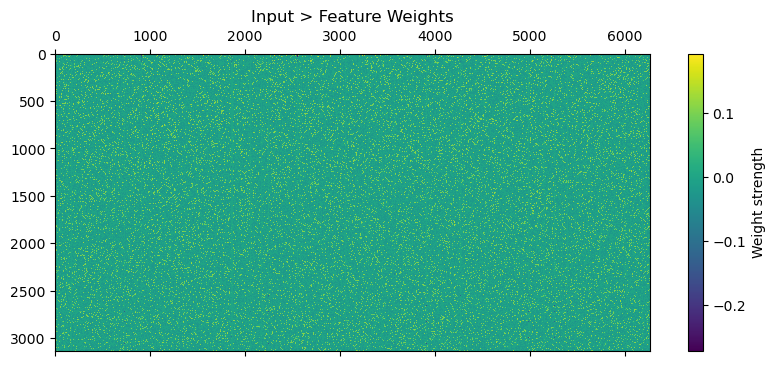

In [15]:
# Load the input to feature excitatory and inhibitory network weights
featureW = np.load('./mats/1_BasicDemo/featureW.npy')

# Plot the  weights
plt.matshow(featureW.T)
plt.title('Input > Feature Weights')
plt.colorbar(shrink=0.8, label="Weight strength")

# Display the plots
plt.show()

In this case, we have more inhibitory connections than we do excitatory for the input to feature layer. Let's load the feature to output layer spikes and visualise them.

In [ ]:
# Load the input to feature excitatory and inhibitory network weights
fo_exc = np.load('./mats/0_basicdemo/fo_exc.npy')
fo_inh = np.load('./mats/0_basicdemo/fo_inh.npy')

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # Adjust the figure size as needed

# Plot the excitatory weights
exc_plot = axes[0].matshow(fo_exc)
axes[0].set_title('Feature > Output Excitatory Weights')
fig.colorbar(exc_plot, ax=axes[0], shrink=0.4, label="Weight strength")

# Plot the inhibitory weights
inh_plot = axes[1].matshow(fo_inh, cmap='viridis_r')
axes[1].set_title('Feature > Output Inhibitory Weights')
fig.colorbar(inh_plot, ax=axes[1], shrink=0.4, label="Weight strength")

# Display the plots
plt.show()

### Propagate network spikes

Now we'll propagate the input spikes across the layers to get the output. All we have to do is multiply the input spikes by the Input > Feature weights for both excitatory and inhibitory matrices and add them, then take the feature spikes and multiply them by the Feature > Output weights and do the smae thing. We'll also clamp spikes in the range of [0, 0.9] to prevent negative spikes and spike explosions.

Let's do that and visualize the spikes as they're going through, we'll start with the Input to Feature layer.

In [ ]:
# Calculate feature spikes (positive and negative weights)
feature_spikes = np.matmul(if_exc,patch_1d) + np.matmul(if_inh,patch_1d)
feature_spikes = np.clip(feature_spikes, 0, 0.9)

# Now create the line plot
plt.plot(np.arange(len(feature_spikes)), feature_spikes)

# Add title and labels if you wish
plt.title('Feature Layer Spikes')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')

# Show the plot
plt.show()

Now let's propagate the feature layer spikes through to the output layer.

In [ ]:
# Calculate output spikes (positive and negative weights)
output_spikes = np.matmul(fo_exc,feature_spikes) + np.matmul(fo_inh,feature_spikes)
output_spikes = np.clip(output_spikes, 0, 0.9)

# Now create the line plot
plt.plot(np.arange(len(output_spikes)), output_spikes)

# Add title and labels if you wish
plt.title('Output Layer Spikes')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')

# Show the plot
plt.show()

Success! We have propagated our input spikes across the layers to reach this output. Clearly, one of the output spikes has the highest amplitude. Our network weights were trained on 500 locations from a Fall and Spring traversal of Nordland. For this example, we passed the first location from the Summer traversal through the network to achieve this output - which clearly looks to have spikes Neuron ID '0' the highest!

Let's prove that.

In [ ]:
# Output the argmax from the output spikes
prediction = np.argmax(output_spikes)
print(f"Neuron ID with the highest output is {prediction}")

### Conclusions

We have gone through a very basic demo of how VPRTempo takes input images, patch normalizes them, and propagates the spikes throughout the weights to achieve the desired matching output. Although this demonstration was performed using NumPy, the torch implementation is virtually the same except we use tensors with or without quantization. 

The purpose of splitting up excitatory and inhibitory weights is to allow for extra hometostatic normalization of inhibitory connections, which has proven to be critical in regulating overall system activity.

If you would like to go more in-depth with training and inferencing, checkout some of the [other tutorials](https://github.com/AdamDHines/VPRTempo-quant/tree/main/tutorials) which show you how to train your own model and goes through the more sophisticated implementation of VPRTempo.